# Advance Lane Finding 

In this project I explore traditional computer vision techniques and create a program which tracks the lane lines in video footage taken from the front of a car.

software requirements:
 * python3
 * openCV
 * numpy


## 1. camera calibration 

When a camera looks at 3D objects in the real world and transforms them into 2D images, a certain amount of information from the world gets distorted due to various factors such as lens curvature etc. We need to correct images taken from the camera by using a distortion matrix before information from the camera images can be used reliably.

A reliable way to calibrate the camera images is to use objects whose (x, y, z) coordinates with respect to the camera are known and correct for the same points on the camera images. To facilitate this idea we can use images of chessboard surfaces where the number of black/white box corners are known to be at a constant space from each other and the z coordinates lie on a flat plane.

The openCV library contains an utility function called ``` find_chessboard_images``` which can be used to determine the coordinates of the points on a given image of a chessboard.
The openCV library also contains an utility function called ```calibrateCamera``` which takes a set of image points and a set of object points and returns the distortion matrix along with other useful tranformation matrices.

I use the ```find_chessboard_images``` functions to determine the corners of chessboard images and generate object points which can be used to find the matrix.

This process is encapsulated in a class called ```Calibrator``` which is initialized in the beginning of the program and contains the undistort method which consistently undistorts images from the camera used to record the footage.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from components.utils import read_image
import cv2
import numpy as np
import glob


def display_original_and_transformed(image, 
                                     transormation_function, 
                                     transormation_title='transformed',
                                     cmap='jet'):
    
    original = image
    transormed = transormation_function(image)
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(1, 2, top=1., bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(original, cmap=cmap)
    ax.axis("off")
    ax.set_title('original image')
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(transormed, cmap=cmap)
    ax2.axis("off")
    ax2.set_title(transormation_title)

In [2]:
from components.calibrator import Calibrator
chessboard_image_sources = glob.glob('camera_cal/calibration*.jpg')
chessboard_images = [read_image(filename) for filename in chessboard_image_sources]
calibrator = Calibrator(chessboard_images)

demonstration of test calibration results

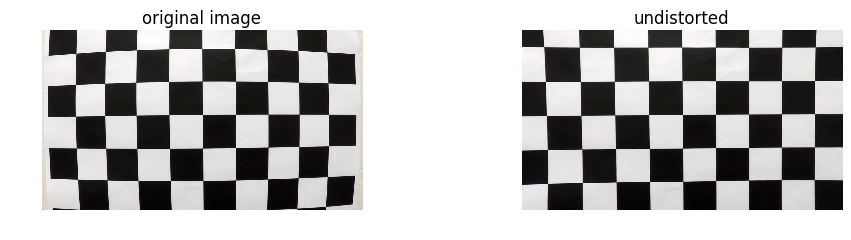

In [3]:
display_original_and_transformed(chessboard_images[0], calibrator.undistort, 'undistorted')

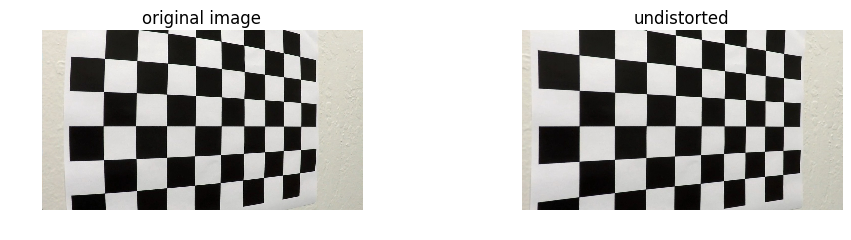

In [4]:
display_original_and_transformed(chessboard_images[15], calibrator.undistort, 'undistorted')

now that we know the calibration is working, lets apply it to the test image

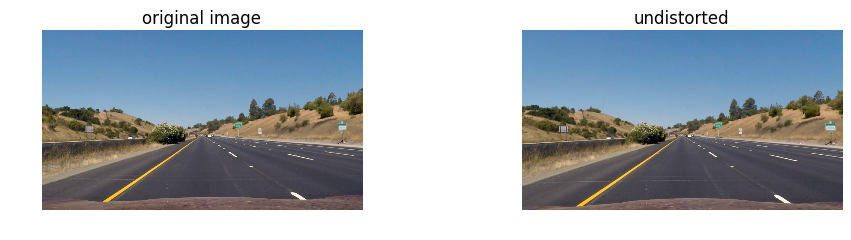

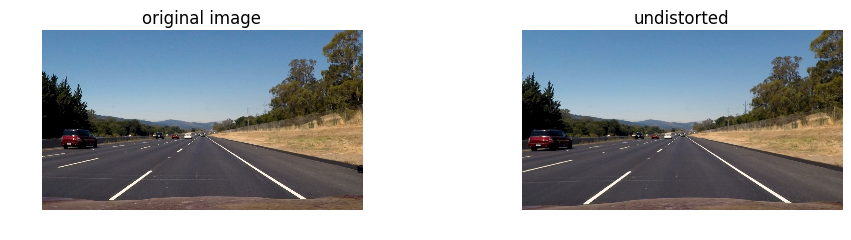

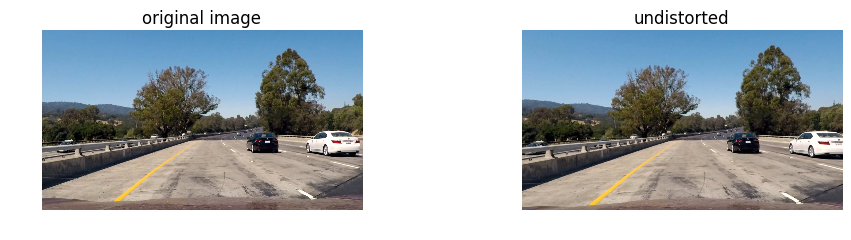

In [5]:
from components.pipeline import ImagePipeline
image_pipeline = ImagePipeline()
image_pipeline.add(calibrator.undistort)

test_image_files = glob.glob('test_images/*.jpg')
test_images = [read_image(imfile) for imfile in test_image_files]

for im  in test_images[:3] :
    display_original_and_transformed(im, image_pipeline.apply, 'undistorted')

## 2. Binary Images

now that we have a birds eye view of the road, i need to be able to clearly distinguish between lane lines and the rest of the road. for this I prepared a Image Binarizer class which apply various operations such as sobel threshholding, colour thresholding etc.

In [6]:
from components.binarizer import ImageBinarizer

In [7]:
image_binarizer = ImageBinarizer(
    sobel_x_thresh=(20, 140),
    sobel_y_thresh=(15, 140),
    mag_thresh=(20, 140),
    dir_thresh=(0, 0.4),
    hls_thresh=(120, 200)
)


def select_y(
    sobel_x_min,
    sobel_x_max,
    sobel_y_min,
    sobel_y_max,
    mag_thresh_min,
    mag_thresh_max,
    dir_thresh_min,
    dir_thresh_max,
    hls_thresh_min,
    hls_thresh_max,
    im1,
    im2,
    im3,
    im4):
    image_binarizer.sobel_x_thresh = (sobel_x_min, sobel_x_max)
    image_binarizer.sobel_y_thresh = (sobel_y_min, sobel_y_max)
    image_binarizer.mag_thresh = (mag_thresh_min, mag_thresh_max)
    image_binarizer.dir_thresh = (dir_thresh_min, dir_thresh_max)
    image_binarizer.hls_thresh = (hls_thresh_min, hls_thresh_max)
    im1 = image_binarizer.binarize(im1)
    im2 = image_binarizer.binarize(im2)
    im3 = image_binarizer.binarize(im3)
    im4 = image_binarizer.binarize(im4)
    
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, top=0.5, bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(im1, cmap='gray')
    ax.axis("off")
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(im2, cmap='gray')
    ax2.axis("off")
    
    ax2 = plt.subplot(gs[2])
    plt.imshow(im3, cmap='gray')
    ax2.axis("off")

    ax2 = plt.subplot(gs[3])
    plt.imshow(im4, cmap='gray')
    ax2.axis("off")



<function __main__.select_y>

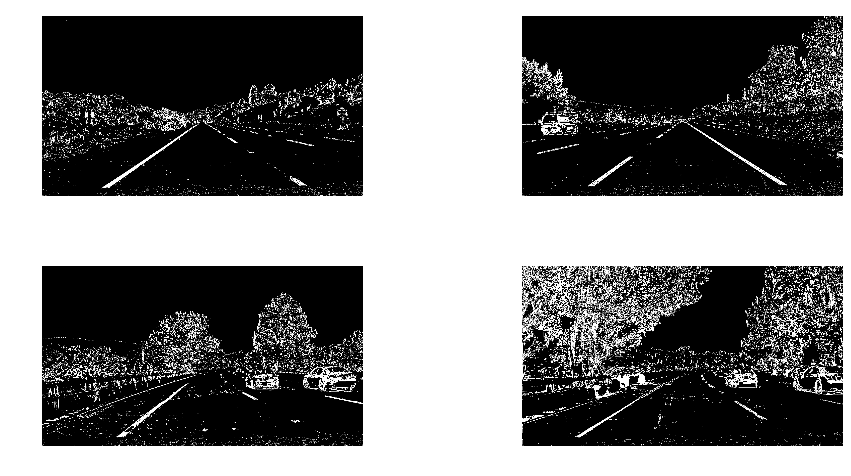

In [8]:
from ipywidgets import interact, fixed, IntSlider, FloatSlider
interact(
    select_y,
    sobel_x_min = IntSlider(min=0, max=255, step=1, value=20),
    sobel_x_max = IntSlider(min=0, max=255, step=1, value=255),
    sobel_y_min = IntSlider(min=0, max=255, step=1, value=32),
    sobel_y_max = IntSlider(min=0, max=255, step=1, value=255),
    mag_thresh_min = IntSlider(min=0, max=255, step=1, value=10),
    mag_thresh_max = IntSlider(min=0, max=255, step=1, value=255),
    dir_thresh_min = FloatSlider(min=0, max=np.pi/2, step=0.01, value=0),
    dir_thresh_max = FloatSlider(min=0, max=np.pi/2, step=0.01, value=0.5),
    hls_thresh_min = IntSlider(min=0, max=255, step=1, value=172),
    hls_thresh_max = IntSlider(min=0, max=255, step=1, value=255),
    im1=fixed(test_images[0]),
    im2=fixed(test_images[1]),
    im3=fixed(test_images[5]),
    im4=fixed(test_images[6]))

In [9]:
image_pipeline.add(image_binarizer.binarize)

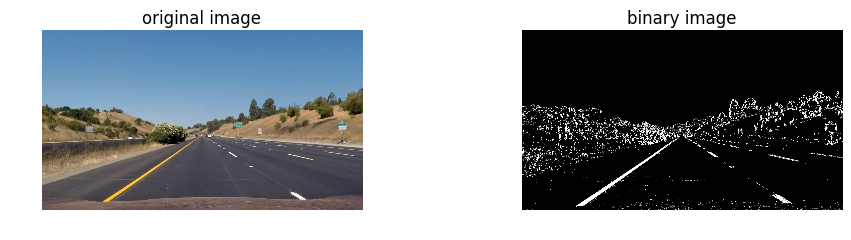

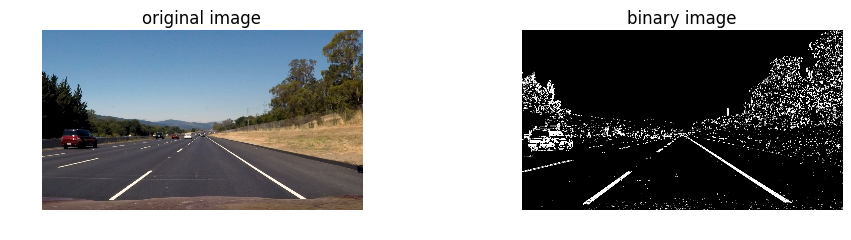

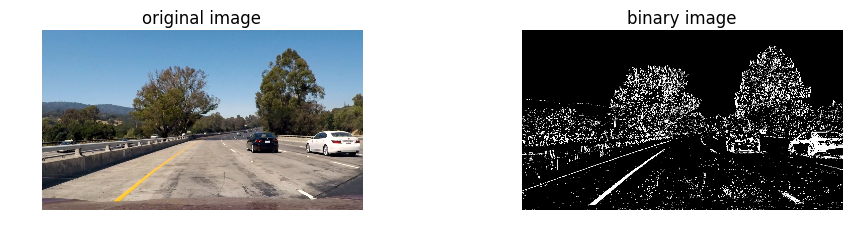

In [10]:
for im  in test_images[:3] :
    display_original_and_transformed(im, image_pipeline.apply, 'binary image', cmap='gray')

## 3.  Perspective Transformation

After correcting the images for camera distortion, I transform the image to get a birds eye view of the road. To do this I created a region selector class which could be interactively updated to choose coordinates for an appropriate region of the image which represents the lane. The chosen region is then transformed using ```cv2.warpTransform``` so that the coordinates represent a rectangle, this allows me to get a birds eye view of the road. 

In [11]:
from components.region_selector import RegionSelector

In [12]:
region_selector = RegionSelector()

In [13]:
def interactive_region_select(bottom_y, top_y, center_x, bottom_width, top_width, image):
    updated_image = region_selector.update_and_show(
        bottom_y,
        top_y,
        center_x,
        bottom_width,
        top_width,
        image
    )
    figure = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, top=0.5, bottom=0., right=0.8, left=0., hspace=0.,
        wspace=0.5)
    
    ax = plt.subplot(gs[0])
    plt.imshow(updated_image, cmap='gray')
    ax.axis("off")
    
    ax2 = plt.subplot(gs[1])
    plt.imshow(region_selector.warp(image), cmap='gray')
    ax2.axis("off")

<function __main__.interactive_region_select>

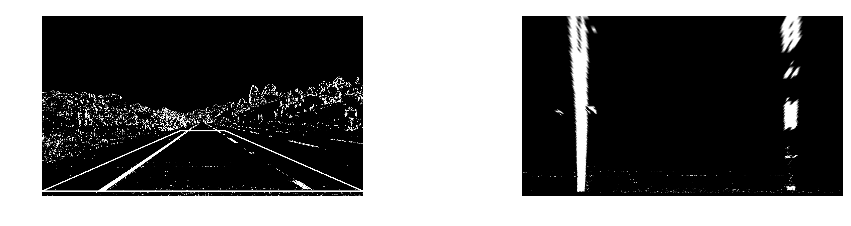

In [14]:

interact(
    interactive_region_select,
    bottom_y = IntSlider(min=0,max=750,step=10,value=700),
    top_y = IntSlider(min=0,max=750,step=10,value=460),
    center_x = IntSlider(min=0,max=1280,step=10,value=640),
    bottom_width = IntSlider(min=0,max=640,step=10,value=640),
    top_width = IntSlider(min=0,max=640,step=10,value=90),
    image=fixed(image_pipeline.apply(test_images[0])))
    

since we are starting to do multiple transformations on the images, i decided to create a pipeline class which lets me compose a series of transformations to the images.

In [15]:
image_pipeline.add(region_selector.warp)

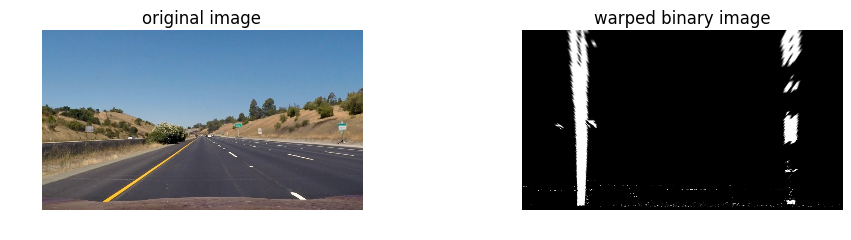

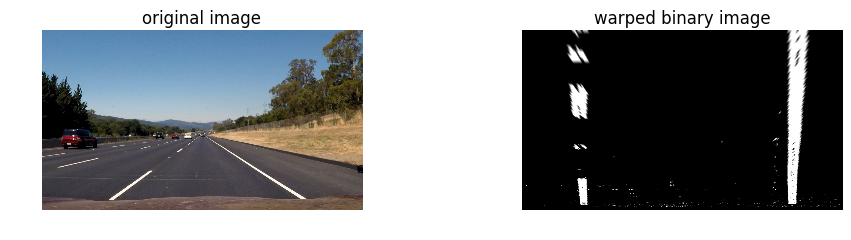

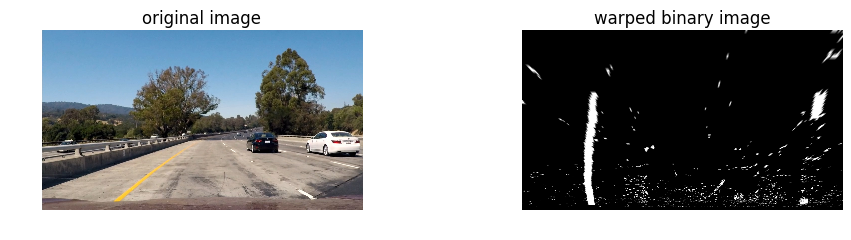

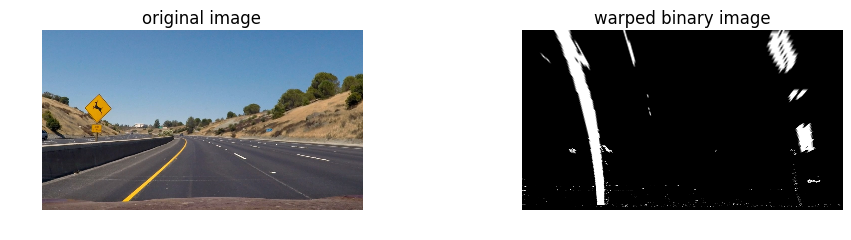

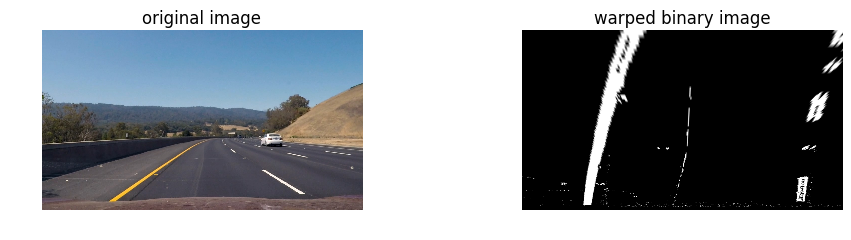

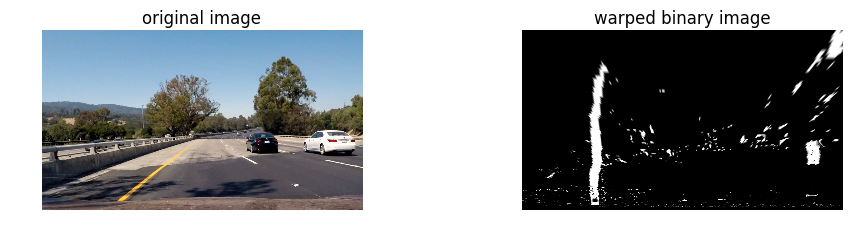

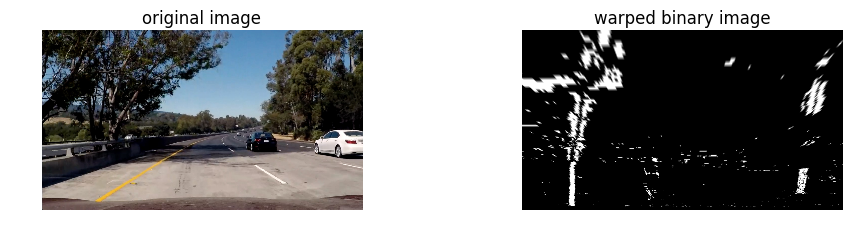

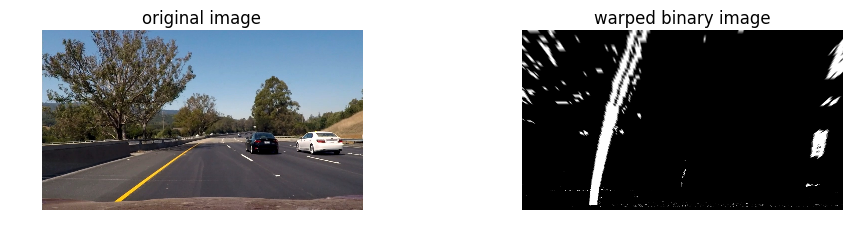

In [16]:
for im  in test_images :
    display_original_and_transformed(im, image_pipeline.apply, 'warped binary image', cmap='gray')

In [17]:
from components.lanefinder import LaneFinder
lane_finder = LaneFinder(image_binarizer,region_selector)

In [18]:
binary_warped = image_pipeline.apply(test_images[0])
left_fitx , right_fitx = lane_finder.show_line(binary_warped)

(720, 0)

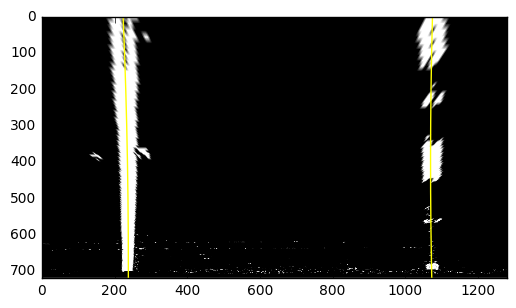

In [19]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
plt.imshow(binary_warped, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [20]:
image_pipeline.add(lane_finder.plot_lane_on_image)

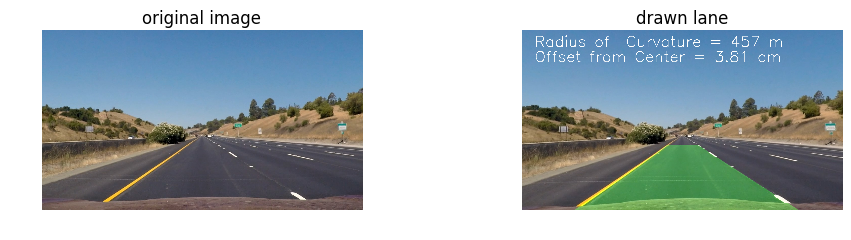

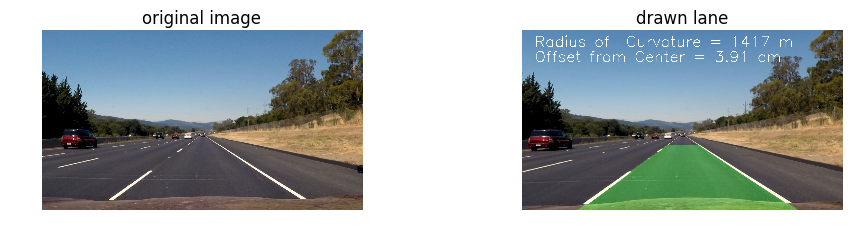

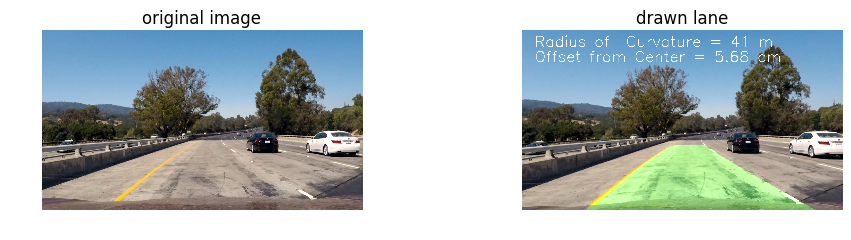

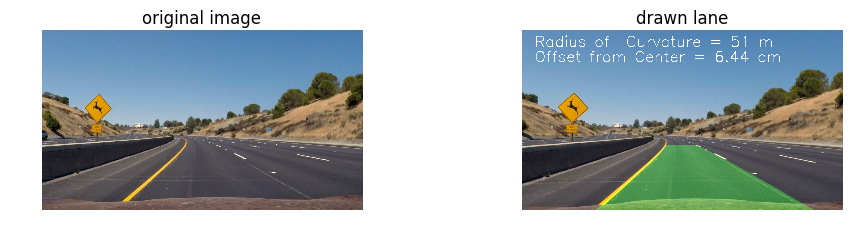

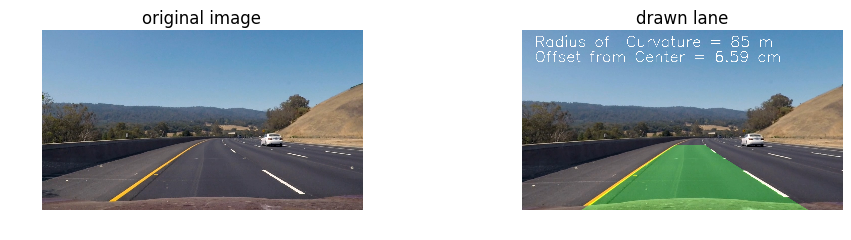

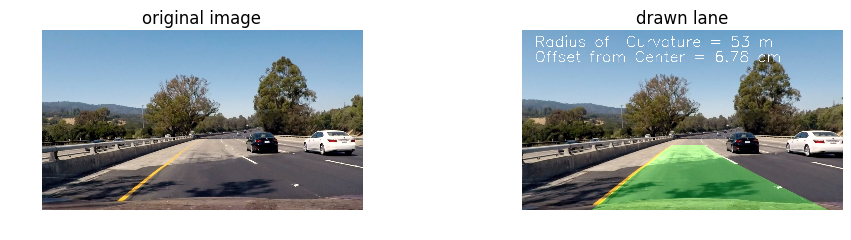

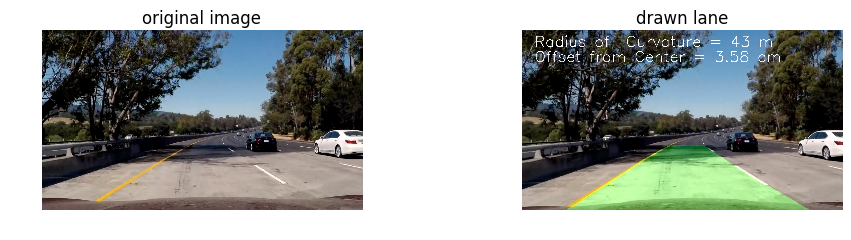

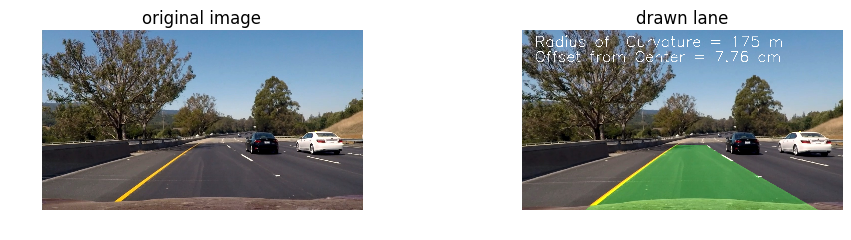

In [21]:
for im  in test_images :
    display_original_and_transformed(im, image_pipeline.apply, 'drawn lane', cmap='gray')

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(image_pipeline.apply) #NOTE: this function expects color images!!
project_clip.write_videofile('main_project_output.mp4', audio=False)

[MoviePy] >>>> Building video main_project_output.mp4
[MoviePy] Writing video main_project_output.mp4


100%|█████████▉| 1260/1261 [06:23<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: main_project_output.mp4 

